In [1]:
!pip install tensorflow


Processing dataset: multisense
Extracted /content/multisense.zip to /content/Multisense
Extracted gaza_war.zip to /content/Multisense/Multisense/gaza_war
Extracted hurricaine_harvey.zip to /content/Multisense/Multisense/hurricaine_harvey
Extracted derna_flood.zip to /content/Multisense/Multisense/derna_flood
Extracted syria_earthquake.zip to /content/Multisense/Multisense/syria_earthquake
Extracted no_damage.zip to /content/Multisense/Multisense/no_damage
Found 53676 files belonging to 5 classes.
Discovered classes: ['derna_flood', 'gaza_war', 'hurricaine_harvey', 'no_damage', 'syria_earthquake']


MBO Feature Selection Iterations: 100%|██████████| 5/5 [02:35<00:00, 31.16s/it]


Feature selection completed: using 114 features.
Random Forest Test Accuracy: 0.9122
                   precision    recall  f1-score   support

      derna_flood       0.88      0.96      0.92      1667
         gaza_war       0.86      0.95      0.90      2088
hurricaine_harvey       0.96      1.00      0.98      3705
        no_damage       0.95      0.69      0.80      1648
 syria_earthquake       0.89      0.84      0.86      1628

         accuracy                           0.91     10736
        macro avg       0.91      0.89      0.89     10736
     weighted avg       0.91      0.91      0.91     10736



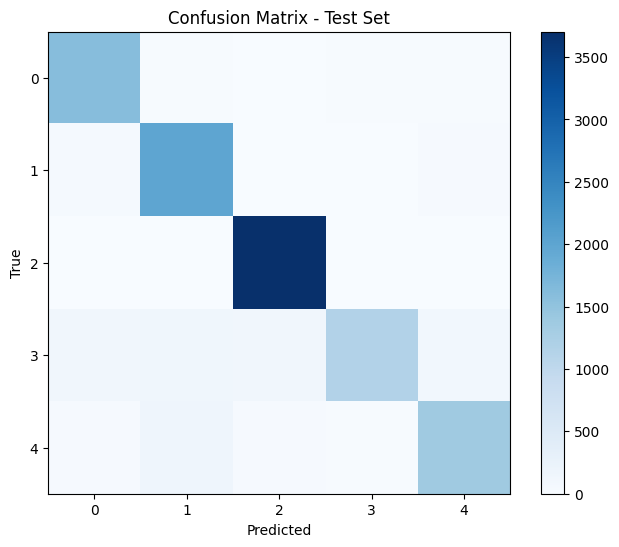


Processing dataset: iiitdmj_smoke
Extracted /content/smoke.zip to /content/IIITDMJ_Smoke
Found 23644 files belonging to 4 classes.
Discovered classes: ['fog_non_smoke', 'fog_smoke', 'non_smoke', 'smoke']


MBO Feature Selection Iterations: 100%|██████████| 5/5 [01:10<00:00, 14.19s/it]


Feature selection completed: using 111 features.
Random Forest Test Accuracy: 0.8882
               precision    recall  f1-score   support

fog_non_smoke       0.89      0.85      0.87      1339
    fog_smoke       0.88      0.92      0.90      1070
    non_smoke       0.89      0.89      0.89      1364
        smoke       0.90      0.91      0.90       957

     accuracy                           0.89      4730
    macro avg       0.89      0.89      0.89      4730
 weighted avg       0.89      0.89      0.89      4730



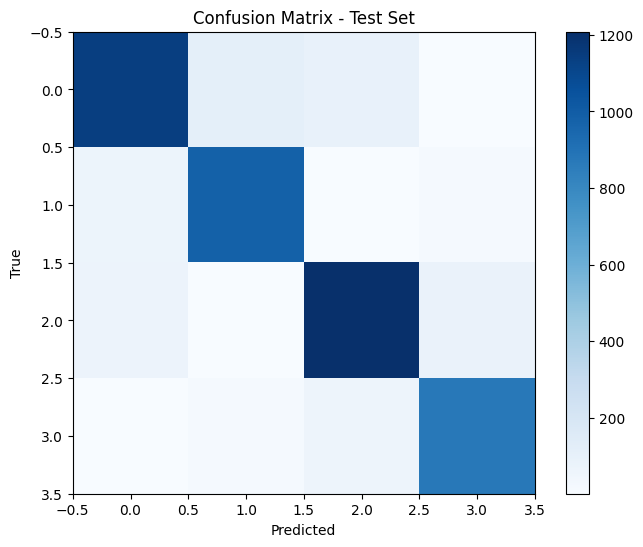


Processing dataset: gastroendonet
Extracted /content/gastroendonet.zip to /content/GastroEndoNet
Found 24036 files belonging to 4 classes.
Discovered classes: ['Gerd', 'Gerd Normal', 'Polyp', 'Polyp Normal']


MBO Feature Selection Iterations: 100%|██████████| 5/5 [01:17<00:00, 15.41s/it]


Feature selection completed: using 117 features.
Random Forest Test Accuracy: 0.6972
              precision    recall  f1-score   support

        Gerd       0.67      0.61      0.64      1169
 Gerd Normal       0.65      0.77      0.70      1324
       Polyp       0.81      0.53      0.64       935
Polyp Normal       0.72      0.81      0.76      1380

    accuracy                           0.70      4808
   macro avg       0.71      0.68      0.69      4808
weighted avg       0.71      0.70      0.69      4808



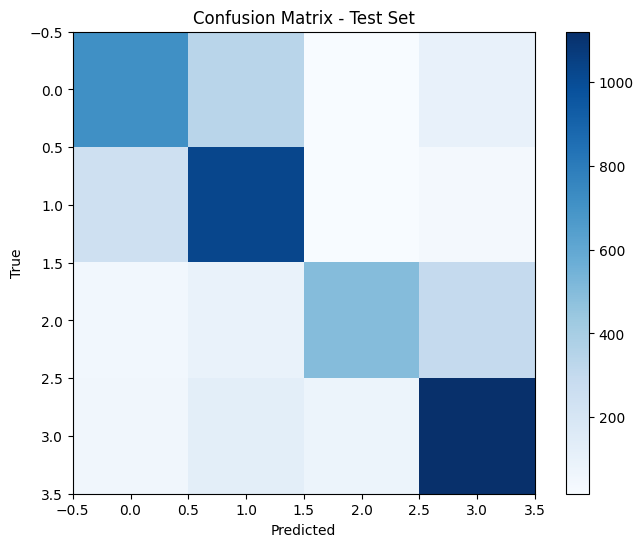


=== Final Results ===
multisense: Test Accuracy = 0.9122
iiitdmj_smoke: Test Accuracy = 0.8882
gastroendonet: Test Accuracy = 0.6972


In [ ]:
import os
import zipfile
import requests
import tensorflow as tf
import numpy as np
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from pathlib import Path
import shutil

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

DATASET_CONFIG = {
    'multisense': {
        'download_url': 'https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/krkft96n43-1.zip',
        'zip_path': './content/multisense.zip',
        'base_folder': './content/Multisense',
        'image_size': (224, 224),
        'class_zip': True
    },
    'iiitdmj_smoke': {
        'download_url': 'https://data.mendeley.com/public-files/datasets/4mn2g8cnsf/files/48d746ea-229f-46d2-b97e-977b585157ec/file_downloaded',
        'zip_path': './content/smoke.zip',
        'base_folder': './content/IIITDMJ_Smoke',
        'image_size': (224, 224),
        'class_zip': False
    },
    'gastroendonet': {
        'download_url': 'https://data.mendeley.com/public-files/datasets/ffyn828yf4/files/e40ec933-4112-4eae-bedd-d0197d1e2d71/file_downloaded',
        'zip_path': './content/gastroendonet.zip',
        'base_folder': './content/GastroEndoNet',
        'image_size': (224, 224),
        'class_zip': False
    }
}

def download_file(url, dest_path):
    print(f"Downloading {url} → {dest_path}")
    response = requests.get(url, stream=True)
    if response.ok:
        with open(dest_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Downloaded {dest_path}")
    else:
        print(f"Failed to download {url} with status code {response.status_code}")

def extract_multisense_class_zips(multisense_dir):
    for zipfile_name in os.listdir(multisense_dir):
        if zipfile_name.endswith('.zip'):
            class_name = zipfile_name.replace('.zip', '')
            class_folder = os.path.join(multisense_dir, class_name)
            os.makedirs(class_folder, exist_ok=True)
            zip_path = os.path.join(multisense_dir, zipfile_name)
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(class_folder)
            print(f"Extracted {zipfile_name} to {class_folder}")

def extract_zip_with_structure_handling(zip_path, extract_to, dataset_key):
    cfg = DATASET_CONFIG[dataset_key]
    dataset_folder = Path(extract_to) / Path(cfg['base_folder']).name
    os.makedirs(dataset_folder, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_folder)
    print(f"Extracted {zip_path} to {dataset_folder}")

    if dataset_key == 'iiitdmj_smoke':
        inner = None
        for sub in ["IIITDMJ_Smoke", "iiitdmj_smoke"]:
            maybe = dataset_folder / sub
            if maybe.exists():
                inner = maybe
                break
        if inner is None:
            inner = dataset_folder
        combined_folder = dataset_folder / 'combined'
        os.makedirs(combined_folder, exist_ok=True)
        for split in ['train', 'test', 'val']:
            split_path = inner / split
            if split_path.exists():
                for class_folder in split_path.iterdir():
                    if class_folder.is_dir():
                        dest_class_folder = combined_folder / class_folder.name
                        os.makedirs(dest_class_folder, exist_ok=True)
                        for img_file in class_folder.glob('*'):
                            if img_file.is_file():
                                target_file = dest_class_folder / img_file.name
                                if not target_file.exists():
                                    shutil.copy(img_file, target_file)
        return combined_folder
    elif dataset_key == 'multisense':
        inner_multisense_dir = dataset_folder / Path(cfg['base_folder']).name
        if inner_multisense_dir.exists():
            extract_multisense_class_zips(inner_multisense_dir)
            return inner_multisense_dir
        else:
            extract_multisense_class_zips(dataset_folder)
            return dataset_folder
    else:
        return dataset_folder

def load_dataset_images(folder, image_size, batch_size=32):
    ds = keras.utils.image_dataset_from_directory(
        folder,
        labels="inferred",
        label_mode="int",
        batch_size=batch_size,
        image_size=image_size,
        seed=SEED,
        shuffle=True
    )
    return ds, ds.class_names

def create_vgg16_feature_extractor(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(256, activation='relu', name='feature_layer')
    ])
    return model

def extract_features(model, dataset):
    features, labels = [], []
    for imgs, lbls in tqdm(dataset, desc="Feature extraction"):
        f = model(imgs, training=False)
        features.append(f.numpy())
        labels.append(lbls.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

def mbo_feature_selection(X_train, y_train, X_val, y_val, num_butterflies=10, max_iter=5):
    rng = np.random.default_rng(SEED)
    num_features = X_train.shape[1]
    def fitness(solution):
        solution = np.asarray(solution).astype(int)
        if np.sum(solution) < 5:
            return 0.0
        X_sel = X_val[:, solution == 1]
        clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=SEED)
        try:
            score = np.mean(cross_val_score(clf, X_sel, y_val, cv=3, scoring='accuracy', n_jobs=-1))
            return score - 0.002 * np.sum(solution)
        except:
            return 0.0

    population = rng.integers(0, 2, (num_butterflies, num_features))
    for iteration in tqdm(range(max_iter), desc="MBO Feature Selection Iterations"):
        fitness_scores = np.array([fitness(ind) for ind in population])
        idx = fitness_scores.argsort()[::-1]
        population = population[idx]
        for i in range(len(population)):
            donor = population[rng.integers(0, num_butterflies)]
            mutation = rng.random(num_features) < 0.12
            population[i][mutation] = donor[mutation]
            flip = rng.random(num_features) < 0.02
            population[i][flip] = 1 - population[i][flip]

    best = population[np.argmax([fitness(ind) for ind in population])]
    indices = np.where(best == 1)[0]
    return indices

def train_and_evaluate_random_forest(X_train, y_train, X_test, y_test, selected_features, class_names):
    X_train_sel = X_train[:, selected_features]
    X_test_sel = X_test[:, selected_features]
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=SEED)
    clf.fit(X_train_sel, y_train)
    preds = clf.predict(X_test_sel)
    acc = accuracy_score(y_test, preds)
    print(f"Random Forest Test Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds, target_names=class_names))
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap='Blues')
    plt.title("Confusion Matrix - Test Set")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.show()
    return clf, acc

def process_dataset(dataset_key):
    cfg = DATASET_CONFIG[dataset_key]
    print(f"\nProcessing dataset: {dataset_key}")

    if not os.path.exists(cfg['zip_path']):
        download_file(cfg['download_url'], cfg['zip_path'])

    data_folder = extract_zip_with_structure_handling(cfg['zip_path'], extract_to='/content', dataset_key=dataset_key)
    ds, class_names = load_dataset_images(str(data_folder), cfg['image_size'], batch_size=32)
    print(f"Discovered classes: {class_names}")

    feature_extractor = create_vgg16_feature_extractor(cfg['image_size'] + (3,))
    ds = ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(tf.data.AUTOTUNE)

    features, labels = extract_features(feature_extractor, ds)

    # Split: 70% train, 10% val, 20% test
    X_train, X_temp, y_train, y_temp = train_test_split(
        features, labels, test_size=0.3, random_state=SEED, stratify=labels
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=2/3, random_state=SEED, stratify=y_temp
    )

    # Feature selection using validation set
    selected_features = mbo_feature_selection(X_train, y_train, X_val, y_val)
    print(f"Feature selection completed: using {len(selected_features)} features.")

    if len(selected_features) == 0:
        selected_features = np.argsort(np.var(X_train, axis=0))[-32:]
        print("Fallback: using 32 highest-variance features.")

    # Train and evaluate on test set
    clf, test_acc = train_and_evaluate_random_forest(X_train, y_train, X_test, y_test, selected_features, class_names)

    return test_acc

def main():
    results = {}
    for dataset in DATASET_CONFIG.keys():
        acc = process_dataset(dataset)
        results[dataset] = acc
    print("\n=== Final Results ===")
    for ds, acc in results.items():
        print(f"{ds}: Test Accuracy = {acc:.4f}")

if __name__ == "__main__":
    main()


In [ ]:
# the code doesn't need anything to be done, everything will be downloaded, unzipped andd extracted(features) automatically in google collab, if we need ot run the code in vsc, the data_config paths need to be changed
#or we can just make a content ddirectory in vsc and if we give relative paths here, then no changes will be needed in the code
